In [3]:
import pandas as pd
import numpy as np
import os

import nltk

import torch
!pip install transformers
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import files
uploaded = files.upload()

Saving FA18_messages_with_gender_recipients_hand_lableled.xlsx to FA18_messages_with_gender_recipients_hand_lableled (1).xlsx


In [5]:
# Read in excel file with recipient gender hand labeled 
df_fall_18_messages = pd.read_excel('FA18_messages_with_gender_recipients_hand_lableled.xlsx', index_col=0)
print(df_fall_18_messages.shape)
df_fall_18_messages.head()

(5039, 5)


,User ID,Sender Race,Sender Gender,Recipient Gender,Text
0,42683026,WHITE,F,F,Hey @Katie Poteet I know you said we should em...
1,25501571,WHITE,F,F,@Mary Cassell I would email Dr. K anyway with ...
2,42683026,WHITE,F,F,"Ok, thanks a lot. I have the email typed but w..."
3,25501571,WHITE,F,F,Upstairs from our lecture hall
4,25501571,WHITE,F,F,Sherman 207!!!


In [6]:
# Encode recipient gender char as int and create as new column in dataframe
# Remove rows where recipient's gender is unknown
male_val = 0
female_val = 1
neutral_val = 2

def encode(c):
    if (c == 'M'):
        return male_val
    elif (c == 'F'):
        return female_val
    elif (c == 'N'):
        return neutral_val

# Add column in dataframe for encoded gender
df_fall_18_messages['Recipient Gender Encoded'] = [encode(x) for x in df_fall_18_messages['Recipient Gender']]
# Drop nas (some genders were unknown in the dataset)
df_fall_18_messages = df_fall_18_messages[df_fall_18_messages['Recipient Gender Encoded'].notna()]

data = [df_fall_18_messages['Text'], df_fall_18_messages['Recipient Gender Encoded']]

headers = ['Text', 'Recipient Gender Encoded']

df_fall_18_messages = pd.concat(data, axis=1, keys=headers)

print(df_fall_18_messages.shape)
df_fall_18_messages.head()

(4872, 2)


,Text,Recipient Gender Encoded
0,Hey @Katie Poteet I know you said we should em...,1.0
1,@Mary Cassell I would email Dr. K anyway with ...,1.0
2,"Ok, thanks a lot. I have the email typed but w...",1.0
3,Upstairs from our lecture hall,1.0
4,Sherman 207!!!,1.0


In [7]:
nltk.download('punkt')
df_fall_18_sentences = pd.DataFrame(columns=['Sentence', 'RecipientGender'])
counter = 0
for index, row in df_fall_18_messages.iterrows():
    for sentence in nltk.tokenize.sent_tokenize(row['Text']):
        values_to_add = {'Sentence': sentence, 'Recipient Gender': row['Recipient Gender Encoded']}
        row_to_add = pd.Series(values_to_add, name = counter)
        df_fall_18_sentences = df_fall_18_sentences.append(row_to_add)
        counter =+ 1

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
print(np.argwhere(np.isnan(np.array(df_fall_18_sentences['Recipient Gender']))))
print(df_fall_18_sentences.shape)
df_fall_18_sentences.head()

[]
(6354, 3)


,Sentence,RecipientGender,Recipient Gender
0,Hey @Katie Poteet I know you said we should em...,NaN,1.0
1,I’m planning to do the Baltimore Community Too...,NaN,1.0
1,@Mary Cassell I would email Dr. K anyway with ...,NaN,1.0
1,"If not, it’s still good for her to know what y...",NaN,1.0
1,"Ok, thanks a lot.",NaN,1.0


In [9]:
print(df_fall_18_sentences['Recipient Gender'].value_counts())

2.0    2918
1.0    1794
0.0    1642
Name: Recipient Gender, dtype: int64


In [10]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [11]:
tokenized = df_fall_18_sentences['Sentence'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [12]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [13]:
np.array(padded).shape

(6354, 105)

In [14]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(6354, 105)

In [15]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [16]:
X = last_hidden_states[0][:,0,:].numpy()
y = df_fall_18_sentences["Recipient Gender"]

In [17]:
df_features = pd.DataFrame(X)
df_features.head()
from google.colab import drive
drive.mount('drive')
df_features.to_excel('bert_features.xlsx')
!cp bert_features.xlsx "drive/My Drive/"

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [18]:
# Print y shape, head, unique values and number of instances in each class
print(y.shape)
print(y.unique())
print(y.value_counts())

(6354,)
[1. 2. 0.]
2.0    2918
1.0    1794
0.0    1642
Name: Recipient Gender, dtype: int64


In [19]:
# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Train/Test splitting
from sklearn import model_selection

# Hyper-parameter tuning
from sklearn.model_selection import RandomizedSearchCV,  GridSearchCV, cross_val_score

# Classifiers
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Classifier evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer, confusion_matrix, classification_report

# Print confusion matrix
import seaborn as sns

In [20]:
# split into training and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5083, 768)
(5083,)
(1271, 768)
(1271,)


In [21]:
print(np.argwhere(np.isnan(np.array(y_train))))

[]


In [22]:
svm_clf = SVC(C=10, gamma=0.1, probability=True)
rf_clf = RandomForestClassifier(max_depth=50, min_samples_leaf=3, min_samples_split=3)
mlp_clf = MLPClassifier(alpha=0.05, hidden_layer_sizes=(50, 100, 50))

In [23]:
svm_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
mlp_clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [24]:
def print_results(clf, y_pred):
    # Print accuracy score 
    print("Accuracy Score -> ",accuracy_score(y_pred, y_test)*100)
    
    # Print confusion matrix (heat map)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
    print(classification_report(y_test, y_pred))
    
    # Print avarage 10-fold cross validation accuracy and f1 scores 
    #svm_cv_accuracy_score = cross_val_score(clf, X_train, y_train, cv=10,scoring='accuracy')
    #svm_cv_f1_score = cross_val_score(clf, X_train, y_train, cv=10,scoring='f1_macro')
    #print("Mean cv accuracy: ", svm_cv_accuracy_score.mean())
    #print("Mean cv f1_macro: ", svm_cv_f1_score.mean())

Accuracy Score ->  54.99606608969315
              precision    recall  f1-score   support

         0.0       0.41      0.36      0.38       321
         1.0       0.49      0.40      0.44       364
         2.0       0.64      0.74      0.69       586

    accuracy                           0.55      1271
   macro avg       0.51      0.50      0.50      1271
weighted avg       0.54      0.55      0.54      1271



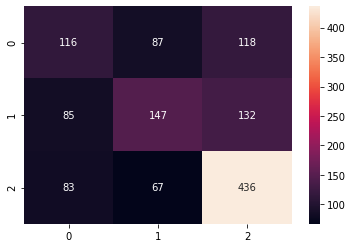

In [25]:
# predict recipient gender and print prediction results
y_pred = svm_clf.predict(X_test)
print_results(svm_clf, y_pred) 

Accuracy Score ->  52.39968528717546
              precision    recall  f1-score   support

         0.0       0.45      0.18      0.26       321
         1.0       0.43      0.32      0.37       364
         2.0       0.56      0.84      0.67       586

    accuracy                           0.52      1271
   macro avg       0.48      0.45      0.43      1271
weighted avg       0.50      0.52      0.48      1271



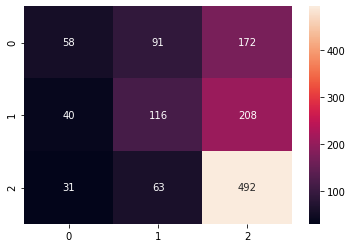

In [26]:
# predict recipient gender and print prediction results
y_pred = rf_clf.predict(X_test)
print_results(rf_clf, y_pred)

Accuracy Score ->  47.67899291896145
              precision    recall  f1-score   support

         0.0       0.34      0.36      0.35       321
         1.0       0.38      0.40      0.39       364
         2.0       0.63      0.59      0.61       586

    accuracy                           0.48      1271
   macro avg       0.45      0.45      0.45      1271
weighted avg       0.48      0.48      0.48      1271



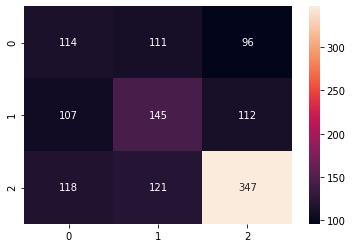

In [27]:
# predict recipient gender and print prediction results
y_pred = mlp_clf.predict(X_test)
print_results(mlp_clf, y_pred)

Accuracy Score ->  34.93312352478363
              precision    recall  f1-score   support

         0.0       0.23      0.24      0.23       321
         1.0       0.29      0.30      0.30       364
         2.0       0.46      0.44      0.45       586

    accuracy                           0.35      1271
   macro avg       0.33      0.33      0.33      1271
weighted avg       0.35      0.35      0.35      1271



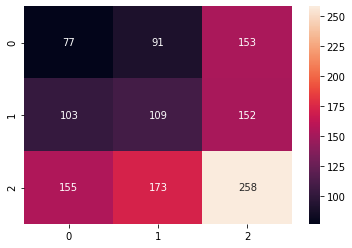

In [38]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()
clf.fit(X_train, y_train)

# predict recipient gender and print prediction results
y_pred = clf.predict(X_test)
print_results(clf, y_pred)